<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/stock-predictions/blob/master/lab.ipynb">link</a>

Helper functions:


In [0]:
import pandas as pd

def one_hot(dataframe, column):
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([dataframe, pd.get_dummies(dataframe[column], prefix=column)], axis=1)
    # now drop the original column (you don't need it anymore)
    df.drop([column], axis=1, inplace=True)

    return df

def inner_join(df1, df2, column):
    return pd.concat([df1.set_index(column),df2.set_index(column)], axis=1, join='inner').reset_index()

def where_equal(df, column, value):
    return df[df[column] == value]

def week_from_date(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df['week'] = df[column].dt.week
    df = df = one_hot(df, 'week')
    return df

def lags(df, range, key):
    ds = df[key]
    df.drop([key], axis=1, inplace=True)
    stocks = 1115
    concatable = [df, ds.fillna(0)]
    for i in range:
        concatable.append(ds.shift(stocks * i).fillna(0).rename(f'{key}_{i}'))
    return pd.concat(concatable, axis=1)

Now we write our **classificator** for reducing incoming data dimensionality and grouping similar providers. We will use [AgglomerativeClustering](https://https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) for this purpose:

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import numpy as np


train = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
store_states = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store_states.csv')
store = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store.csv')


def get_store_data():
    df = inner_join(store_states, store, 'Store')
    df = one_hot(df, 'State')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')
    agg = train.groupby('Store')['Sales'].agg([pd.np.mean]).reset_index()
    df = pd.concat([df, agg], axis=1)

    df.drop([
            'PromoInterval',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear'
        ], axis=1, inplace=True)
    
    return df.loc[:,~df.columns.duplicated()]

train_data = get_store_data()
train_data.drop(['Store'], axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(train_data)

print(standardized_data)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,200))

#visualizer.fit(standardized_data)  # Fit the data to the visualizer
#visualizer.show()  # Finalize and render the figure

K = 300 # num of clusters
model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')# KMeans(n_clusters=K)
predicted = model.fit_predict(standardized_data)

print(predicted)
store.insert(loc=0, column='K', value=predicted)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.88857955]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.80190926]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.01078783]
 ...
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
  -0.12081961]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
   5.59115669]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
  -0.2630245 ]]
[  6  96   5 ... 202 261 204]


First pipeline - data processing, including: one-hot encoding, adding time lags and so on

In [0]:
def get_data():
    df = one_hot(train, 'DayOfWeek')
    df = week_from_date(df, 'Date')
    store = get_store_data()

    df = inner_join(df, store, 'Store')
    #df = one_hot(df, 'StoreType')
    #df = one_hot(df, 'Assortment')
    df = one_hot(df, 'K')
    # df = one_hot(df, 'Store')
    # df = lags(df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14], 'Sales')

    df.drop([
        'StateHoliday',
        'SchoolHoliday',
        'Date',
        #'Store',
        #'Customers',
    ], axis=1, inplace=True)

    # df = where_equal(df, 'Store', 1)
    # print(list(df))

    return df

def to_3d(n=1115):
    df = get_data()
    olap = []
    for i in range(n):
        olap.append(where_equal(df, 'Store', i))

    return olap

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1774)              681216    
_________________________________________________________________
hidden_2 (Dense)             (None, 1183)              2099825   
_________________________________________________________________
hidden_3 (Dense)             (None, 591)               699744    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 592       
Total params: 3,481,377
Trainable params: 3,481,377
Non-trainable params: 0
_________________________________________________________________
None
[5263 5020 4782 5011 6102    0 4364 3706 3769 3464 3558 4395    0 4406
 4852 4427 4767 5042 5054    0 3530 3808 3897 3797 3650 4359    0 4797
 4665 5558 5223 5735 5197    0 4019 3317 3533 3346 3762 3846    0 4097
 4202 4645 4000 4852 551

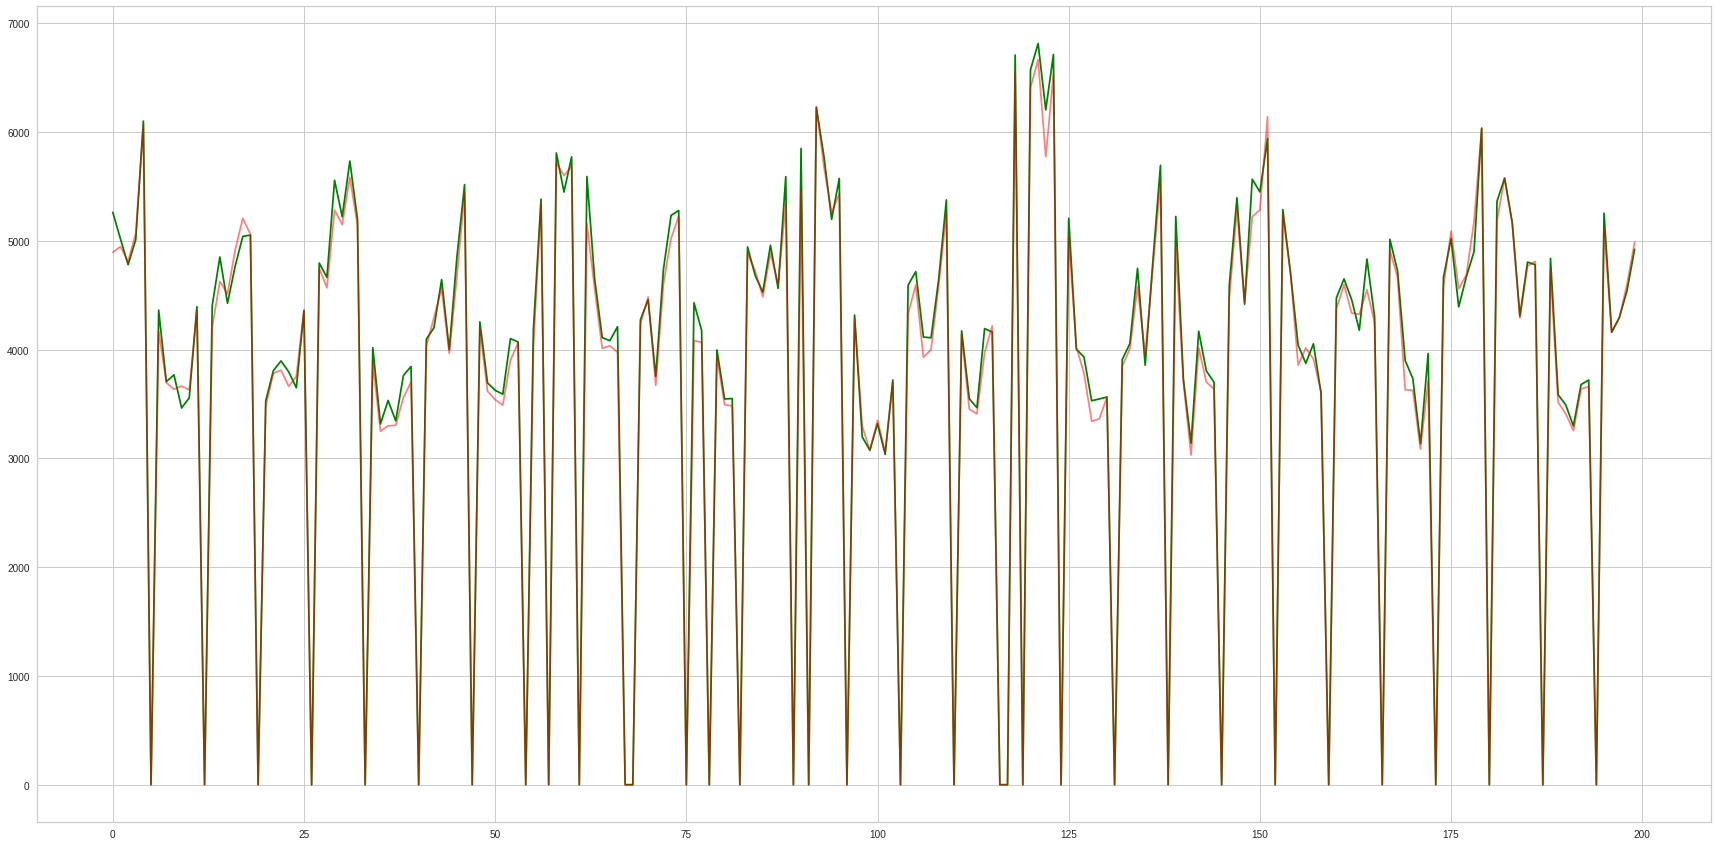

In [10]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

import tensorflow as tf

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = get_data()

scaler.fit(data)

y_vis = data[data['Store'] == 1]['Sales'][0:200]
X_vis = data[data['Store'] == 1][0:200]

y = data[data['Store'] == 1]['Sales']
data.drop(['Sales'], axis=1, inplace=True)
X = data[data['Store'] == 1]

scaler.fit(data)

X_train, X_test = np.split(X, [int(.9 * len(X))])
y_train, y_test = np.split(y, [int(.9 * len(y))])
y_train = np.array(y_train)

n_splits = int((len(X_train)-3) / 3)
tscv = TimeSeriesSplit(n_splits=n_splits)

X_train = scaler.transform(X_train)
X_vis = X_train[0:200]

length, features = X_train.shape

model = Sequential()
model.add(Dense(int(1774), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_1'))
#model.add(Dropout(0.4, name='dropout_1'))
model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_2'))
#model.add(Dropout(0.4, name='dropout_2'))
model.add(Dense(int(591), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_3'))
#model.add(Dropout(0.5, name='dropout_3'))
model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), name='output_layer'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

for train_index, test_index in tscv.split(X_train):
    print(len(train_index))
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train1, y_test1 = y_train[train_index], y_train[test_index]

    model.fit(X_train1, y_train1,
              epochs=5,
              validation_data=(X_test1, y_test1),
              verbose=0)

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

plt.plot(range(200), y_vis, color='green')
plt.plot(range(200), model.predict(X_vis).flatten(), color='red', alpha=0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


942


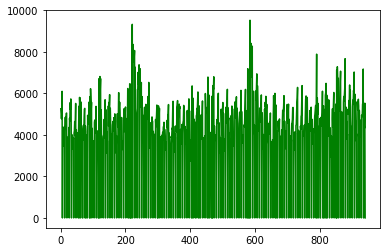

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
data = df[df['Store'] == 1]['Sales']

print(len(data))

plt.plot(range(942), data, color='green')
plt.show()